# Learning curve

### import modules and configure notebook

In [29]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [2]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats



### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to

In [3]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
pickle_model = False
pickle_model_name = 'grouped'
pickle_file_path = '../../../model'
grid_search = False
scale = False

### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

In [4]:
if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### counts of instances in all classes before oversampling

In [5]:
train_data_formodel['class'].value_counts()

22    120
4     105
23    105
16    100
21     74
17     61
24     60
0      53
12     45
14     36
2      36
15     36
6      30
11     30
10     30
7      30
20     28
5      27
8      27
19     27
1      24
13     21
3      18
18     18
9      17
Name: class, dtype: int64

### The class column is stored as the variable y 

In [6]:
y_pre_smote = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [7]:
train_data_feats = train_data_formodel[best_feats]

### address class imbalance using synthetic minority oversampling technique (SMOTE) algorithm

In [8]:

X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(np.array(train_data_feats), y_pre_smote)

In [23]:

my_scaler = StandardScaler()
X_smote_scaled = np.array(my_scaler.fit_transform(X_post_smote))
X_scaled = my_scaler.fit_transform(np.array(train_data_feats))
X = np.array(train_data_feats)
X_smote = np.array(X_post_smote)

### Define function for plotting learning curve

In [11]:
def learningCurve(model, X, y, cv, train_sizes = np.linspace(0.1, 1.0, 20)):
    
    train_sizes, train_scores, test_scores = learning_curve(model, X = X, y = y, cv=cv, n_jobs=-1, train_sizes= train_sizes, shuffle = True, scoring = 'f1_macro', verbose = 2)
    
    train_scores_flat = []
    for i in train_scores:
        for i_2 in i:
            train_scores_flat.append(i_2)
            
    test_scores_flat = []
    for i in test_scores:
        for i_2 in i:
            test_scores_flat.append(i_2)
            
    train_sizes_duped = []
    for i in train_sizes:
        for i_2 in range(0, cv):
            train_sizes_duped.append(i)
            
    df = pd.DataFrame(data = {'train_sizes':train_sizes_duped, 'train_score':train_scores_flat, 'test_scores':test_scores_flat})
    
    df_melt = pd.melt(df, id_vars=['train_sizes'], value_vars=['train_score', 'test_scores'], var_name='train_or_test_data', value_name='k_fold_stratified_scores')
    
    df_melt.sort_values(by = 'train_sizes', ascending=True, inplace=True)
    
    return(df_melt)



### call function for plotting learning curve 

In [12]:
df_smote_rfc = learningCurve(RandomForestClassifier(n_estimators=1700, random_state = random_seed_state, n_jobs=-1, 
                              min_samples_split =  3, min_samples_leaf = 1, max_features = 'auto', 
                              max_depth = 100, bootstrap =  True), X_smote, y_post_smote, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[learning_curve] Training set sizes: [ 240  353  467  581  694  808  922 1035 1149 1263 1376 1490 1604 1717
 1831 1945 2058 2172 2286 2400]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/

In [13]:
df_no_smote_rfc = learningCurve(RandomForestClassifier(n_estimators=1700, random_state = random_seed_state, n_jobs=-1, 
                              min_samples_split =  3, min_samples_leaf = 1, max_features = 'auto', 
                              max_depth = 100, bootstrap =  True), X, y_pre_smote, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[learning_curve] Training set sizes: [ 91 135 178 222 265 309 352 396 439 483 526 570 613 657 700 744 787 831
 874 918]


/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/rmorse/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/extern

In [24]:
df_MLP = learningCurve(MLPClassifier(), X_scaled, y_pre_smote, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[learning_curve] Training set sizes: [ 91 135 178 222 265 309 352 396 439 483 526 570 613 657 700 744 787 831
 874 918]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:   11.1s remaining:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.0s finished


In [27]:
df_MLP_smote = learningCurve(MLPClassifier(), X_smote_scaled, y_post_smote, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[learning_curve] Training set sizes: [ 240  353  467  581  694  808  922 1035 1149 1263 1376 1490 1604 1717
 1831 1945 2058 2172 2286 2400]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:   25.7s remaining:   25.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.2s finished


In [30]:
df_knn = learningCurve(KNeighborsClassifier(), X_smote_scaled, y_post_smote, cv = 5, train_sizes = np.linspace(0.1, 1.0, 20))

[learning_curve] Training set sizes: [ 240  353  467  581  694  808  922 1035 1149 1263 1376 1490 1604 1717
 1831 1945 2058 2172 2286 2400]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed:    2.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.5s finished


### random forest classifier training curve with data oversampled using SMOTE algorithm

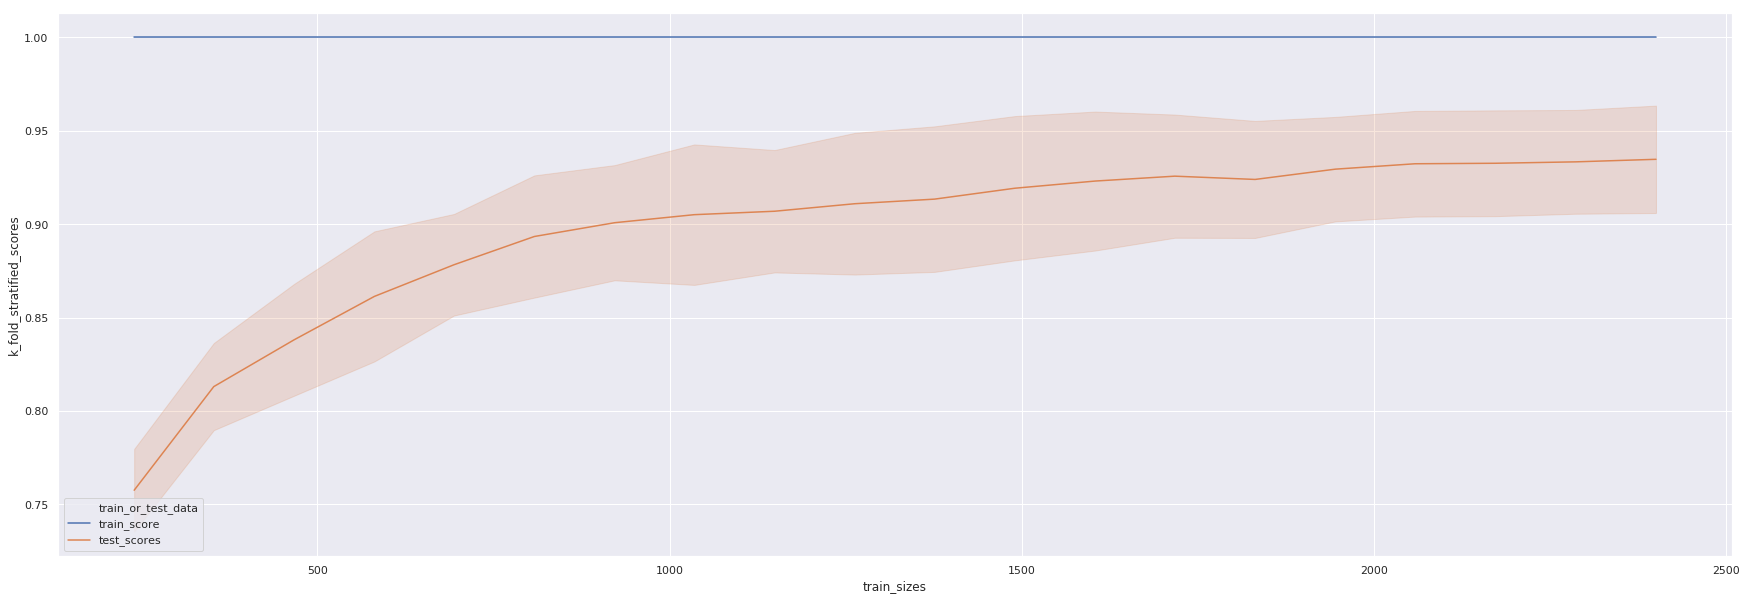

In [17]:
sns.set(rc={'figure.figsize':(30,10)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = df_smote_rfc, ci = 'sd')

### random forest classifier training curve using data not oversampled

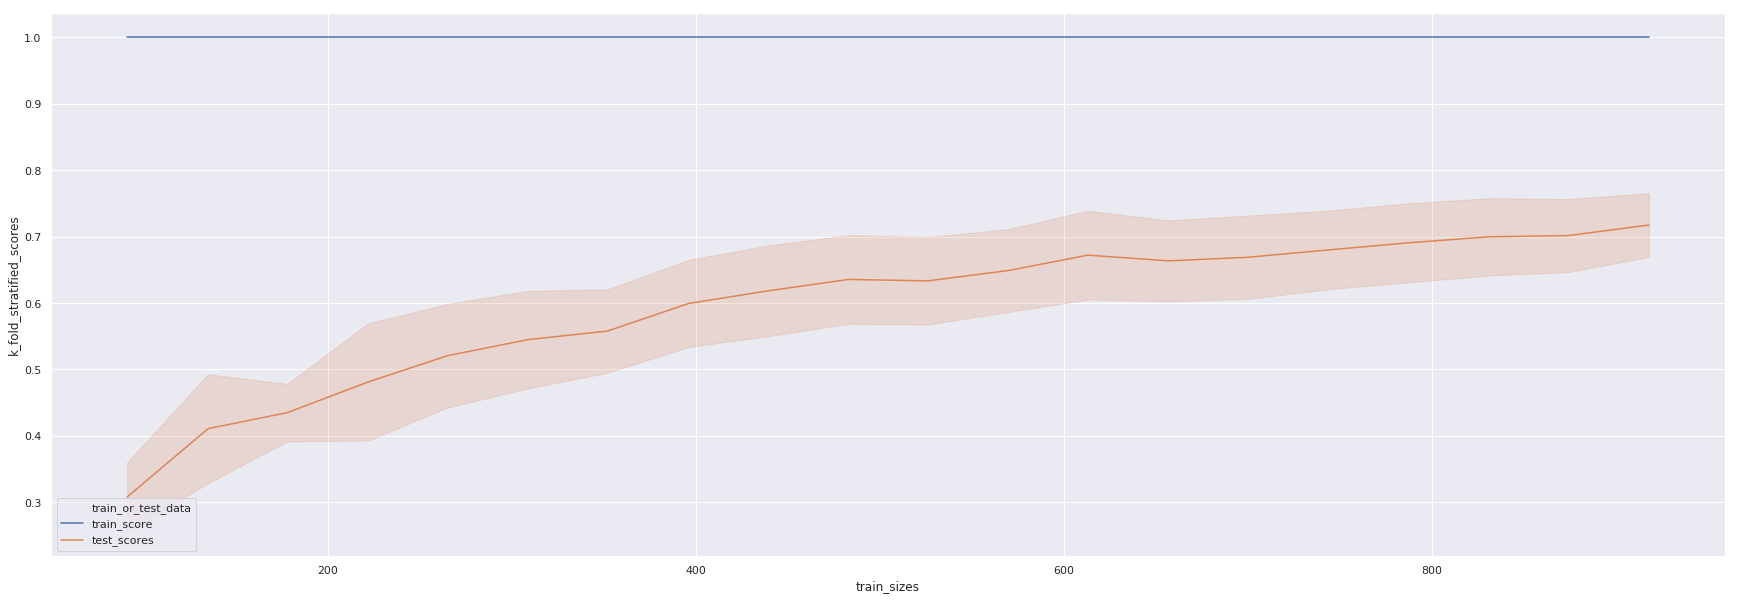

In [18]:
sns.set(rc={'figure.figsize':(30,10)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = df_no_smote_rfc, ci = 'sd')

### multi layer perceptron training curve using data oversampled with SMOTE algorithm

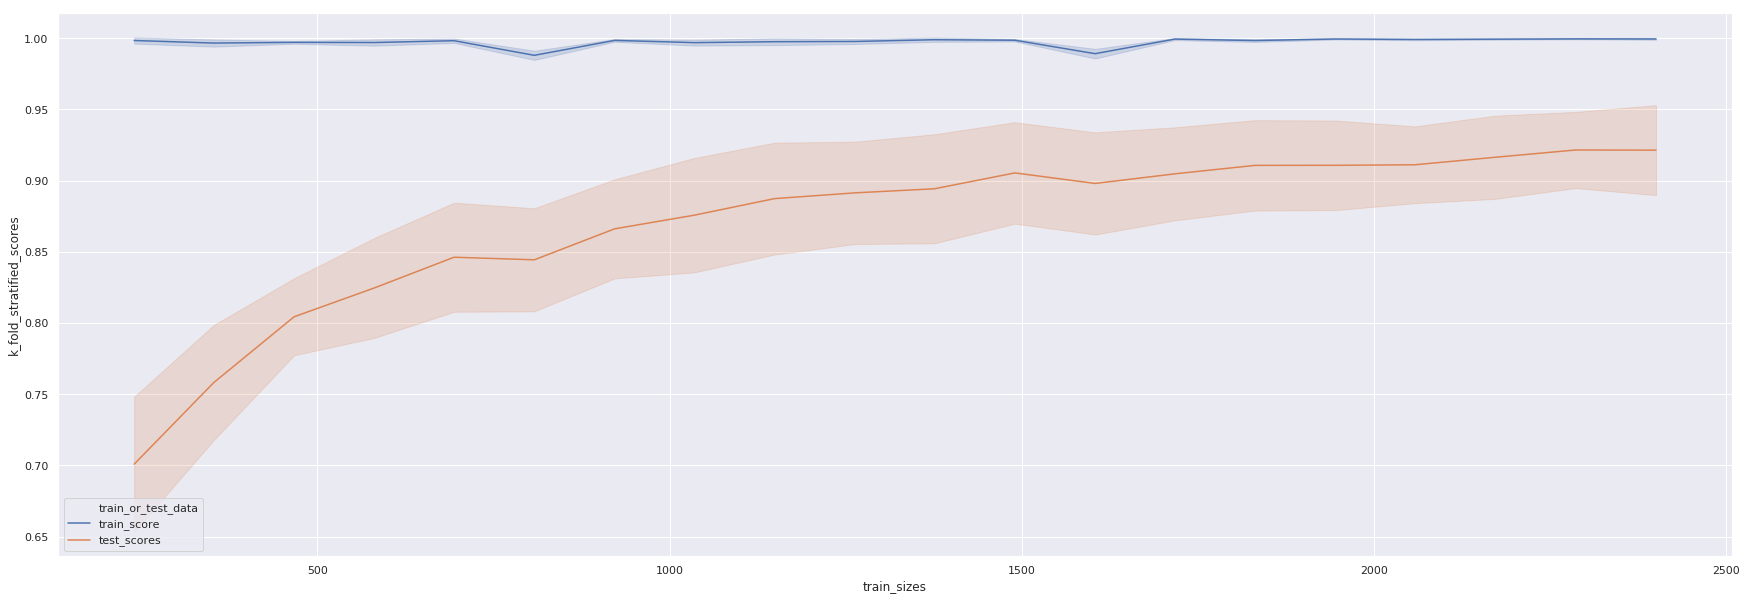

In [28]:
sns.set(rc={'figure.figsize':(30,10)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = df_MLP_smote, ci = 'sd')

### multi layer perceptron training curve using data not oversampled

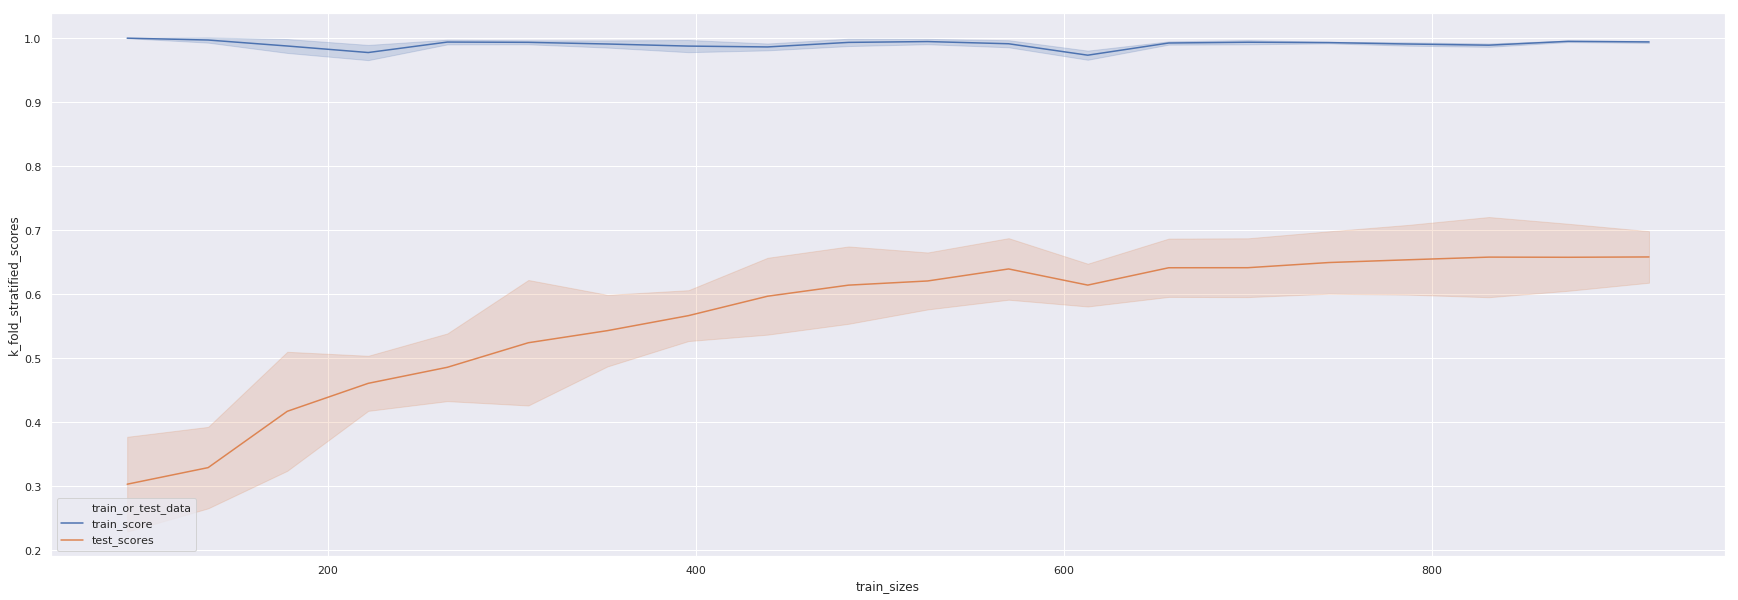

In [25]:
sns.set(rc={'figure.figsize':(30,10)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = df_MLP, ci = 'sd')

### support vector machine training curve using data not oversampled

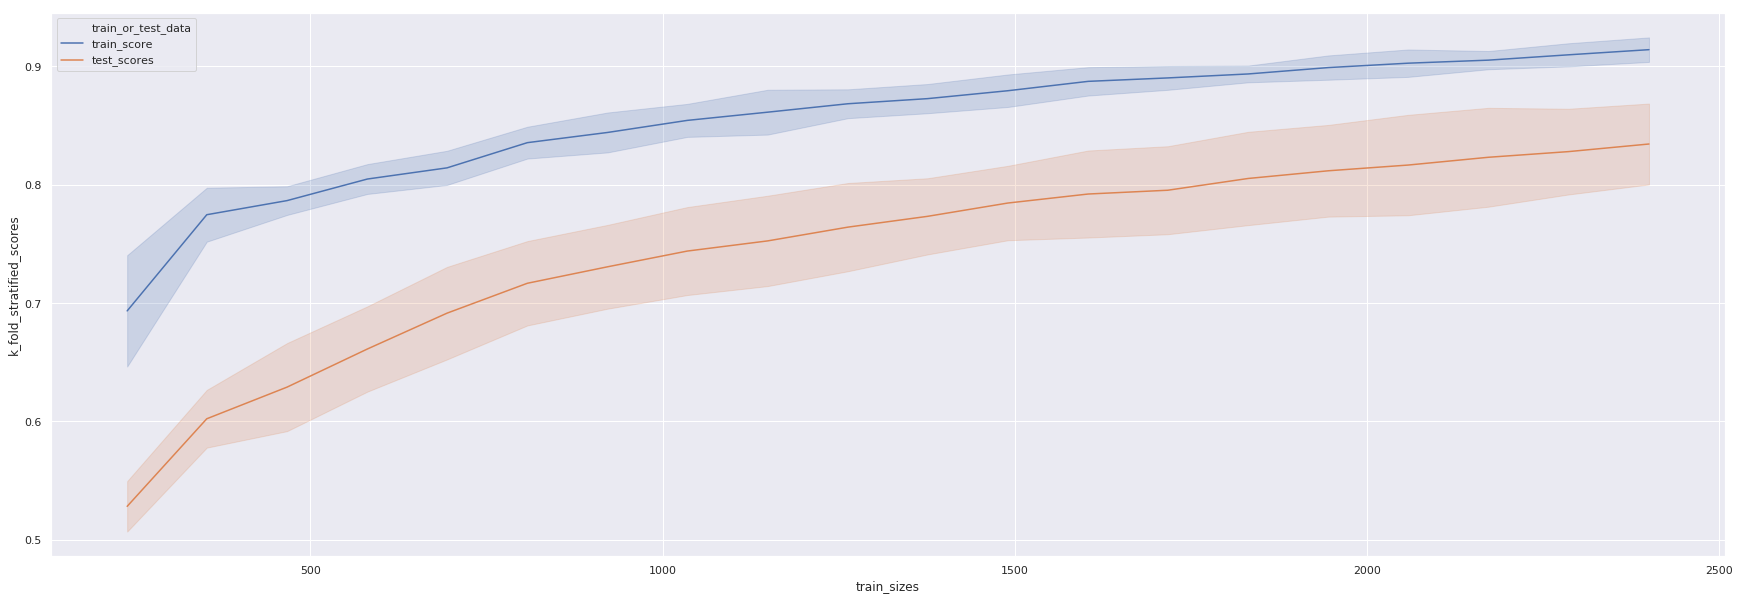

In [31]:
sns.set(rc={'figure.figsize':(30,10)})
plot = sns.lineplot(x = 'train_sizes', y = 'k_fold_stratified_scores', hue = 'train_or_test_data' ,data = df_knn, ci = 'sd')